<a href="https://colab.research.google.com/github/ycw0363/stat_seminar/blob/main/6_a_first_look_at_a_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Apr 14 12:56:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import tensorflow
tensorflow.keras.__version__

'2.4.0'

# A first look at a neural network

This notebook contains the code samples found in Chapter 2, Section 1 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

We will now take a look at a first concrete example of a neural network, which makes use of the Python library Keras to learn to classify 
hand-written digits. Unless you already have experience with Keras or similar libraries, you will not understand everything about this 
first example right away. You probably haven't even installed Keras yet. Don't worry, that is perfectly fine. In the next chapter, we will 
review each element in our example and explain them in detail. So don't worry if some steps seem arbitrary or look like magic to you! 
We've got to start somewhere.

The problem we are trying to solve here is to classify grayscale images of handwritten digits (28 pixels by 28 pixels), into their 10 
categories (0 to 9). The dataset we will use is the MNIST dataset, a classic dataset in the machine learning community, which has been 
around for almost as long as the field itself and has been very intensively studied. It's a set of 60,000 training images, plus 10,000 test 
images, assembled by the National Institute of Standards and Technology (the NIST in MNIST) in the 1980s. You can think of "solving" MNIST 
as the "Hello World" of deep learning -- it's what you do to verify that your algorithms are working as expected. As you become a machine 
learning practitioner, you will see MNIST come up over and over again, in scientific papers, blog posts, and so on.

The MNIST dataset comes pre-loaded in Keras, in the form of a set of four Numpy arrays:

In [2]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


`train_images` and `train_labels` form the "training set", the data that the model will learn from. The model will then be tested on the 
"test set", `test_images` and `test_labels`. Our images are encoded as Numpy arrays, and the labels are simply an array of digits, ranging 
from 0 to 9. There is a one-to-one correspondence between the images and the labels.

Let's have a look at the training data:

퍼미션 에러가 나는 경우도 있는데, sudo 를 사용해서 노트북을 열거나, 에러가 나는 폴더(데이터 저장폴더)의 권한을 쓰기 가능하도록 변경해주어야 합니다. 

In [3]:
train_images.shape

(60000, 28, 28)

In [4]:
len(train_labels)

60000

In [3]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [9]:
train_images.ndim

3

In [10]:
train_images.shape

(60000, 28, 28)

In [11]:
train_images.dtype

dtype('uint8')

In [12]:
import numpy as np
np.max(train_images)

255

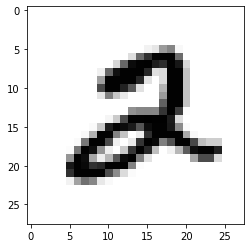

In [14]:
digit = train_images[5]

import matplotlib.pyplot as plt
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

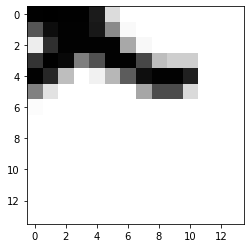

In [15]:
digit = train_images[5, 14: , 14: ]

import matplotlib.pyplot as plt
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

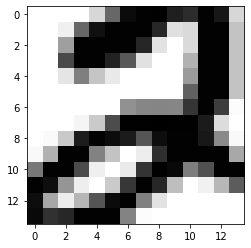

In [16]:
digit = train_images[5, 7:-7, 7:-7]

import matplotlib.pyplot as plt
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

Let's have a look at the test data:

In [4]:
test_images.shape

(10000, 28, 28)

In [5]:
len(test_labels)

10000

In [6]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [18]:
import numpy as np
x = np.array([1,2,3,4,5])
y = np.array([[1,1,1,1,1], [1,1,1,1,1]])

In [19]:
x.shape

(5,)

In [20]:
y.shape

(2, 5)

In [21]:
x+y

array([[2, 3, 4, 5, 6],
       [2, 3, 4, 5, 6]])

relu activation

In [23]:
y = np.array([[1,1,-1,1,1,], [1,-1,1,-2,3]])

z=np.maximum(y,0.)
z

array([[1., 1., 0., 1., 1.],
       [1., 0., 1., 0., 3.]])

In [27]:
x = np.array([[0.,1.], [2.,3.], [4.,5.]])

print(x)
print(x.reshape((6,1)))
print(x.reshape((2,3)))

[[0. 1.]
 [2. 3.]
 [4. 5.]]
[[0.]
 [1.]
 [2.]
 [3.]
 [4.]
 [5.]]
[[0. 1. 2.]
 [3. 4. 5.]]


Our workflow will be as follow: first we will present our neural network with the training data, `train_images` and `train_labels`. The 
network will then learn to associate images and labels. Finally, we will ask the network to produce predictions for `test_images`, and we 
will verify if these predictions match the labels from `test_labels`.

Let's build our network -- again, remember that you aren't supposed to understand everything about this example just yet.

In [7]:
from tensorflow.keras import models
from tensorflow.keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))


The core building block of neural networks is the "layer", a data-processing module which you can conceive as a "filter" for data. Some 
data comes in, and comes out in a more useful form. Precisely, layers extract _representations_ out of the data fed into them -- hopefully 
representations that are more meaningful for the problem at hand. Most of deep learning really consists of chaining together simple layers 
which will implement a form of progressive "data distillation". A deep learning model is like a sieve for data processing, made of a 
succession of increasingly refined data filters -- the "layers".

Here our network consists of a sequence of two `Dense` layers, which are densely-connected (also called "fully-connected") neural layers. 
The second (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each 
score will be the probability that the current digit image belongs to one of our 10 digit classes.

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be 
able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly 
classified).

The exact purpose of the loss function and the optimizer will be made clear throughout the next two chapters.

In [ ]:
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])


Before training, we will preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in 
the `[0, 1]` interval. Previously, our training images for instance were stored in an array of shape `(60000, 28, 28)` of type `uint8` with 
values in the `[0, 255]` interval. We transform it into a `float32` array of shape `(60000, 28 * 28)` with values between 0 and 1.

In [ ]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

We also need to categorically encode the labels, a step which we explain in chapter 3:

In [ ]:
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data.

In [ ]:
network.fit(train_images, train_labels, epochs=5, batch_size=128)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 2s 30us/sample - loss: 0.2543 - accuracy: 0.9263
Epoch 2/5
60000/60000 [==============================] - 3s 49us/sample - loss: 0.1033 - accuracy: 0.9690
Epoch 3/5
60000/60000 [==============================] - 2s 39us/sample - loss: 0.0685 - accuracy: 0.9789
Epoch 4/5
60000/60000 [==============================] - 2s 29us/sample - loss: 0.0496 - accuracy: 0.9847
Epoch 5/5
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0374 - accuracy: 0.9887


Two quantities are being displayed during training: the "loss" of the network over the training data, and the accuracy of the network over 
the training data.

We quickly reach an accuracy of 0.989 (i.e. 98.9%) on the training data. Now let's check that our model performs well on the test set too:

In [ ]:
test_loss, test_acc = network.evaluate(test_images, test_labels)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [ ]:
print('test_acc:', test_acc)

test_acc: 0.9815



Our test set accuracy turns out to be 97.8% -- that's quite a bit lower than the training set accuracy. 
This gap between training accuracy and test accuracy is an example of "overfitting", 
the fact that machine learning models tend to perform worse on new data than on their training data. 
Overfitting will be a central topic in chapter 3.

This concludes our very first example -- you just saw how we could build and a train a neural network to classify handwritten digits, in 
less than 20 lines of Python code. In the next chapter, we will go in detail over every moving piece we just previewed, and clarify what is really 
going on behind the scenes. You will learn about "tensors", the data-storing objects going into the network, about tensor operations, which 
layers are made of, and about gradient descent, which allows our network to learn from its training examples.